In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import random
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Quirky Data Science, Probability, and Statistics
*By [Daniel Lee](https://github.com/dleestat)*

Certain techniques and results from data science, probability, and statistics can be seen as "quirky": interesting, counterintuitive, or strange, yet enlightening. In this notebook, we explore my favorite examples of quirky data science, probability, and statistics.

## Effective Data Imputation

### Problem
During data cleaning, we often come across data sets with missing data. If we wish to make accurate inferences or train a machine learning model on such a data set, we have two workarounds:
1. Listwise deletion of an entire variable or data point containing at least one missing data value.
2. Replacement of missing data values with substituted values. In data science, this process is called data imputation.

The former workaround can result in the loss of a lot of data since we are removing entire variables or data points, leading to less accurate inferences and poor model performance. The latter workaround avoids this loss of data. However, the imputation method must be chosen carefully based on the scenario; an inappropriate imputation method may result in high bias and/or variance.

To be able to choose the most effective imputation method, we must first understand the three main types of missing data.

### Types of Missing Data
Suppose a dataset has variables $X_1, \ldots, X_d$, each of which may contain instances of missing values.

#### Missing Completely at Random (MCAR)
A variable is MCAR if the variable's missingness is independent of itself and independent of other variables; the missingness is unconditionally uniform across rows. Mathematically, $X_i$ is MCAR if and only if

$$P(X_i~\text{is missing}~| X_1, \ldots, X_d) \equiv P(X_i~\text{is missing}).$$

Examples:
- A survey requires all participants to mail in their responses. Independently of time, location, and characteristics of the mail, mail centers lose mail at a constant rate. The survey data is MCAR.
- Independently of time, location, and characteristics of the blood, blood samples get damaged at a constant rate. The blood sample data is MCAR.

Note that since an MCAR variable's missingness of independent of the data, the subset of data points with complete data is itself an (unbiased) random sample of the set of all data points. Thus, it is possible to proceed safely with this subset of data at the cost of higher variance. However, data is rarely MCAR.

#### Missing at Random (MAR)
A variable is MAR if the variable's missingness is independent of itself but dependent on other variables; the missingness is uniform across rows, conditional on other columns. Mathematically, $X_i$ is MAR if and only if

$$P(X_i~\text{is missing}~| X_1, \ldots, X_d) \equiv P(X_i~\text{is missing}~| X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_d).$$

Examples:
- Men may be less inclined to complete a depression survey. The survey data is MAR, dependent on gender.
- A store records all transactions data, including credit card number and age of the purchaser. Younger people are less likely to pay with credit card. Credit card number is MAR, dependent on age.

#### Missing Not at Random (MNAR)
A variable is MNAR if the variable's missingness is dependent on itself (and possibly other variables). Mathematically, $X_i$ is MNAR if and only if

$$P(X_i~\text{is missing}~| X_1, \ldots, X_d)~\text{does not simplify}.$$

Examples:
- A survey has an optional question asking for personal income. Respondents with lower incomes may be less inclined to answer this question. Personal income is MNAR, dependent on income level.
- A person does not attend a drug test because he/she took drugs recently. The drug test data is MNAR, dependent on recent drug use.

---
The below data set contains the gender, height, and weight of 10,000 individuals. We can generate MCAR, MAR, and MNAR data sets using this data set by replacing 30% of the instances of `Weight` with NaN using different methods.

In [2]:
df = pd.read_csv('data/weight-height.csv').sample(frac=1, random_state=0).reset_index(drop=True)
df.head()

,Gender,Height,Weight
0,Female,64.72,138.09
1,Male,67.27,187.36
2,Male,74.52,216.53
3,Female,65.88,131.76
4,Male,64.85,157.72


To generate a MCAR data set, we randomly select 30% of the instances of `Weight` and replace them with NaN.

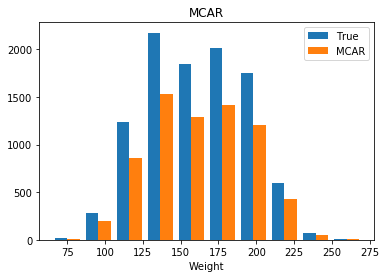

In [3]:
MCAR = df.copy()
np.random.seed(0)
MCAR.loc[df.sample(frac=.3).index, 'Weight'] = np.NaN
plt.hist([df.Weight, MCAR.Weight])
plt.title('MCAR')
plt.xlabel('Weight')
plt.legend(['True', 'MCAR']);

Suppose females are less likely to self-report their weights. To generate a MAR data set, we increase the likelihood of a female having an NaN weight by giving females higher probability weights. We then randomly select 30% of the instances of `Weight` and replace them with NaN, using the new weighting scheme.

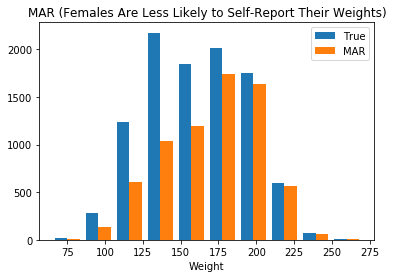

In [4]:
MAR = df.copy()
np.random.seed(0)
MAR.loc[df.sample(frac=.3, weights=df.Gender.replace({'Male':.1, 'Female':.9})).index, 'Weight'] = np.NaN
plt.hist([df.Weight, MAR.Weight])
plt.title('MAR (Females Are Less Likely to Self-Report Their Weights)')
plt.xlabel('Weight')
plt.legend(['True', 'MAR']);

Suppose heavier individuals are less likely to self-report their weights. To generate a MNAR data set, we 
give heavier individuals higher probability weights. We then randomly select 30% of the instances of `Weight` and replace them with NaN, using the new weighting scheme.

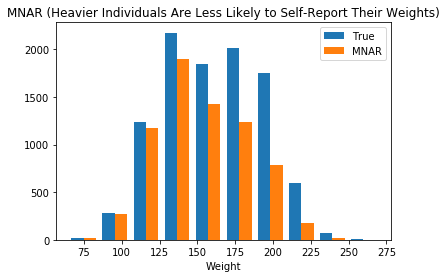

In [5]:
MNAR = df.copy()
np.random.seed(0)
MNAR.loc[df.sample(frac=.3, weights=df.Weight**5).index, 'Weight'] = np.NaN
plt.hist([df.Weight, MNAR.Weight])
plt.title('MNAR (Heavier Individuals Are Less Likely to Self-Report Their Weights)')
plt.xlabel('Weight')
plt.legend(['True', 'MNAR']);

Now that we understand the three main types of missing data, we must understand how to diagnose the type of missing data in a variable.

### Diagnosing the Missing Data Mechanism
The following flowchart outlines the methodology to diagnose the type of missing data in a variable.

<img src='img/missingness.png' style='width: 400px'/>

The word "same" in this flowchart can be made statistically precise by using a statistical model such as goodness of fit.

Note that in the flowchart we are only checking for pairwise independence between the variables $X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_d$ and the variable $X_i$'s missingness. However, showing this is not enough to show that these variables are independent of $X_i$'s missingness, since we are not checking for independence between *combinations* of these variables and the $X_i$'s missingness. In most cases this is empirically difficult to check, so we typically check for pairwise independences and use domain knowledge to confirm that a variable is MCAR.

Also note that we cannot empirically distinguish whether a variable is MAR or MNAR since we would need the unobserved data (which we do not have access to) to check whether a variable is MNAR. Here, we use domain knowledge to determine whether the variable is MAR or MNAR.

---
Now let us see if we can diagnose the missing data mechanisms in the data sets we created. The below function plots the distributions of `Gender` and `Height` by the missingness of `Weight`.

In [6]:
def distributions_by_missingness(df, df_name):
    fig, axes = plt.subplots(1, 2, figsize=[10,3])
    fig.suptitle(f'{df_name} Missingness of Weight', y=1.05, size='x-large')
    (
        df
        .assign(NaN=df.Weight.isna().replace({True:'Weight Missing', False:'Weight Not Missing'}))
        .pivot_table(index='Gender', columns='NaN', aggfunc='size')
        .plot(kind='bar', ax=axes[0], title='Distribution of Gender by Missingness of Weight')
    )
    (
        df
        .assign(NaN=df.Weight.isna().replace({True:'Weight Missing', False:'Weight Not Missing'}))
        .groupby('NaN')
        .Height
        .plot(kind='kde', ax=axes[1], title='Distribution of Height by Missingness of Weight', legend=True)
    )
    axes[1].set_xlabel('Height')
    fig.tight_layout()

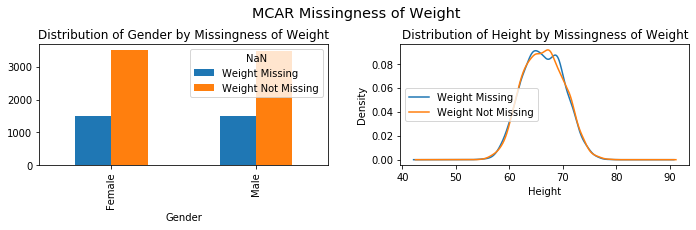

In [7]:
distributions_by_missingness(MCAR, 'MCAR')

For the MCAR data set, we can graphically see that the distributions of `Gender` and `Height` appear the same whether or not `Weight` is missing. Because of these pairwise independences, it is likely that this data set is MCAR as expected.

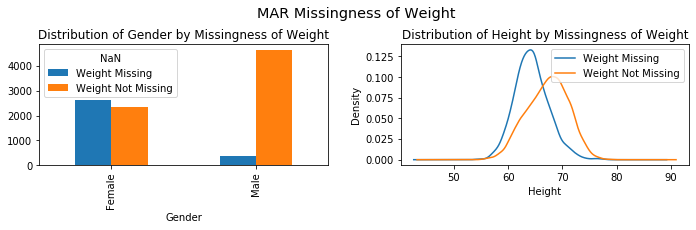

In [8]:
distributions_by_missingness(MAR, 'MAR')

For the MAR data set, we can graphically see that the distributions of `Gender` and `Height` appear different depending on whether `Weight` is missing. It is likely that this data set is either MAR or MNAR as expected but we cannot determine which without further domain knowledge.

Note that because of the correlation between `Gender` and `Height` (females tend to be shorter), eliminating `Weight` of more female entries appears to be associated with eliminating `Weight` of shorter individuals.

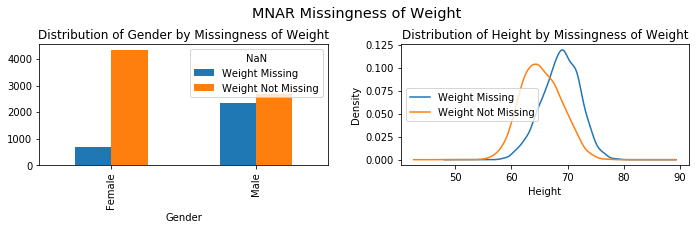

In [9]:
distributions_by_missingness(MNAR, 'MNAR')

For the MNAR data set, we can again graphically see that the distributions of `Gender` and `Height` appear different depending on whether `Weight` is missing. Again, it is likely that this data set is either MAR or MNAR as expected but we cannot determine which without further domain knowledge.

Note that because of the correlation between `Gender`, `Height`, and `Weight` (males tend to be taller and heavier), eliminating `Weight` of heavier individuals appears to be associated with eliminating `Weight` of more males and taller individuals.

An example of using domain knowledge to distinguish whether the last data set (`MNAR`) is MAR or MNAR is to use a different data set (one that includes heavier individuals) to train a regressor that predicts weight from gender and height, and predict `Weight` of all individuals in our data set who have missing `Weight` values. We can then check whether or not the last data set is MNAR by exploring whether or not our data set appears to be systematically missing `Weight` values for heavier individuals, regardless of gender.

Now that we understand the three main types of missing data and how to diagnose the type of missing data in a variable, we must understand how to deal with missing data.

### Imputation Techniques

In [10]:
def evaluate_imputation(weight, ax, title):
    """
    Plot the true and imputed distributions of weight and report the RMSE between true and imputed values.
    Only compare non-null values.
    """
    ax.hist([df.Weight, weight])
    ax.set_title(f'{title} (RMSE: {np.sqrt(mean_squared_error(df.Weight[weight.notna().sort_index()], weight.dropna().sort_index())):.1f})')
    ax.set_xlabel('Weight')
    ax.legend(['True', 'Imputed'])

#### Listwise Deletion
To perform listwise deletion, we delete all data points with missing `Weight` values. We can use `.dropna()` for this.

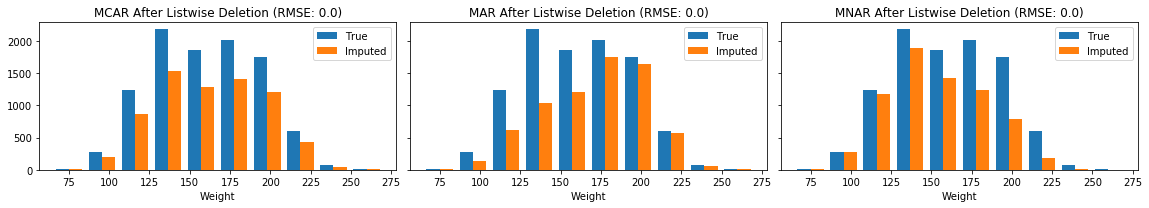

In [11]:
fig, axes = plt.subplots(1, 3, figsize=[16,3], sharex=True, sharey=True)
evaluate_imputation(MCAR.Weight, axes[0], 'MCAR After Listwise Deletion')
evaluate_imputation(MAR.Weight, axes[1], 'MAR After Listwise Deletion')
evaluate_imputation(MNAR.Weight, axes[2], 'MNAR After Listwise Deletion')
fig.tight_layout()

Notes:
- `MCAR.Weight` after listwise deletion is a random sample of `df.Weight`.
- `MAR.Weight` after listwise deletion is a biased sample of `df.Weight` since the missingness of `Weight` is dependent on `Gender`, where females (who tend to be lighter) are less likely to self-report their `Weight`.
- `MNAR.Weight` after listwise deletion is a biased sample of `df.Weight` since the missingness of `Weight` is dependent on `Weight` itself, where heavier individuals are less likely to self-report their `Weight`.

Pros:
- Listwise deletion is easy to implement.
- Listwise deletion of a MCAR variable results in an (unbiased) random sample, preserving the characteristics of the original distribution.

Cons:
- Since we are deleting data points, we end up with less data.
- Listwise deletion will bias a non-MCAR variable.

#### Forward/Backward Fill

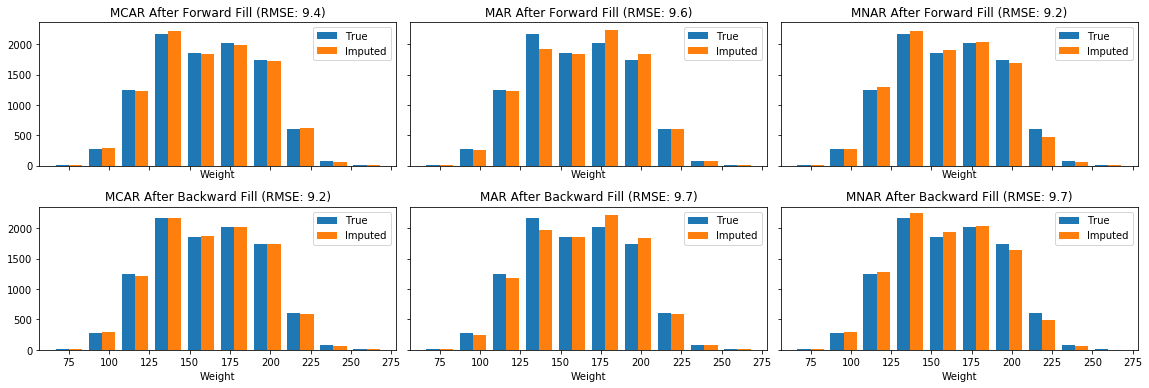

In [12]:
fig, axes = plt.subplots(2, 3, figsize=[16,5.5], sharex=True, sharey=True)
evaluate_imputation(MCAR.sort_values('Height').Weight.fillna(method='ffill'), axes[0,0], 'MCAR After Forward Fill')
evaluate_imputation(MAR.sort_values('Height').Weight.fillna(method='ffill'), axes[0,1], 'MAR After Forward Fill')
evaluate_imputation(MNAR.sort_values('Height').Weight.fillna(method='ffill'), axes[0,2], 'MNAR After Forward Fill')
evaluate_imputation(MCAR.sort_values('Height').Weight.fillna(method='bfill'), axes[1,0], 'MCAR After Backward Fill')
evaluate_imputation(MAR.sort_values('Height').Weight.fillna(method='bfill'), axes[1,1], 'MAR After Backward Fill')
evaluate_imputation(MNAR.sort_values('Height').Weight.fillna(method='bfill'), axes[1,2], 'MNAR After Backward Fill')
fig.tight_layout()

#### Mean (Median, Mode) Imputation
To perform mean (median, mode) imputation, we replace missing data values with the variable's mean (median, mode). If we know a variable is MAR, we replace missing data values with the variable's mean (median, mode), conditional on the variable(s) the missing data value is dependent on. For NMAR variables, we have no such special handling and are forced to use marginal mean (median, mode) imputation as in case of MCAR variables.

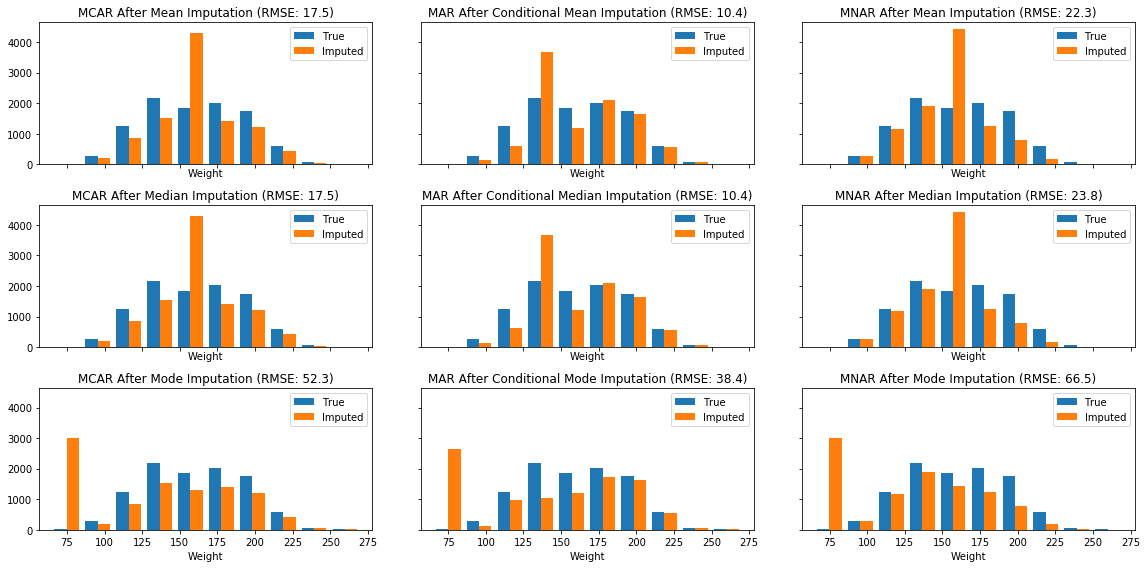

In [13]:
fig, axes = plt.subplots(3, 3, figsize=[16,8], sharex=True, sharey=True)
evaluate_imputation(MCAR.Weight.fillna(MCAR.Weight.mean()), axes[0,0], 'MCAR After Mean Imputation')
means = MAR.groupby('Gender').Weight.mean()
evaluate_imputation(MAR.apply(lambda x: means[x.Gender] if pd.isnull(x.Weight) else x.Weight, 1), axes[0,1], 'MAR After Conditional Mean Imputation')
evaluate_imputation(MNAR.Weight.fillna(MNAR.Weight.mean()), axes[0,2], 'MNAR After Mean Imputation')
evaluate_imputation(MCAR.Weight.fillna(MCAR.Weight.median()), axes[1,0], 'MCAR After Median Imputation')
medians = MAR.groupby('Gender').Weight.median()
evaluate_imputation(MAR.apply(lambda x: medians[x.Gender] if pd.isnull(x.Weight) else x.Weight, 1), axes[1,1], 'MAR After Conditional Median Imputation')
evaluate_imputation(MNAR.Weight.fillna(MNAR.Weight.median()), axes[1,2], 'MNAR After Median Imputation')
evaluate_imputation(MCAR.Weight.fillna(MCAR.Weight.mode()[0]), axes[2,0], 'MCAR After Mode Imputation')
modes = MAR.groupby('Gender').Weight.agg(lambda x: x.mode()[0])
evaluate_imputation(MAR.apply(lambda x: modes[x.Gender] if pd.isnull(x.Weight) else x.Weight, 1), axes[2,1], 'MAR After Conditional Mode Imputation')
evaluate_imputation(MNAR.Weight.fillna(MNAR.Weight.mode()[0]), axes[2,2], 'MNAR After Mode Imputation')
fig.tight_layout()

In [14]:
print(f'{df.Weight.count()} out of {df.Weight.nunique()} weights in df are unique.')

10000 out of 10000 weights in df are unique.


Notes:
- Since the distributions of `MCAR.Weight`, `MAR.Weight`, and `MNAR.Weight` are roughly symmetric, the respective means and medians are similar. Thus, mean imputation and median imputation are roughly equivalent.
- `MCAR.Weight` and `MAR.Weight` after mean and median imputation are unbiased but have an artificially low variance.
- `MNAR.Weight` after mean and median imputation is biased and has an artifically low variance.
- Every `Weight` is unique. Thus when choosing a mode, an arbitrary `Weight` is chosen; in this case,  the smallest `Weight`. Thus, mode imputation results in extreme bias here.

Pros:
- Mean (median, mode) imputation is easy to implement.
- Mean and median imputation of a MCAR or MAR variable results in an (unbiased) random sample, preserving the characteristics of the original distribution.

Cons:
- Mean (median, mode) artifically lowers a variable's variance. This can cause issues when making inferences or when training a machine learning model, since we would want an accurate representation of the true distribution, including its variance. 
- Mode imputation can heavily bias a variable depending on the location of the mode(s).
- Mean (median, mode) imputation will bias a MNAR variable.

#### Probabilistic Imputation

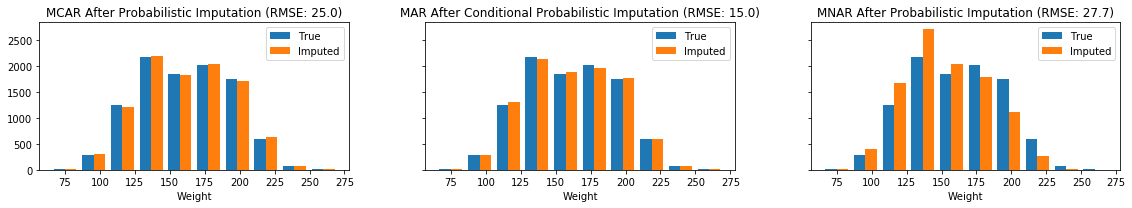

In [15]:
fig, axes = plt.subplots(1, 3, figsize=[16,3], sharex=True, sharey=True)
np.random.seed(0)
evaluate_imputation(MCAR.apply(lambda x: MCAR.Weight.dropna().sample().squeeze() if pd.isnull(x.Weight) else x.Weight, 1), axes[0], 'MCAR After Probabilistic Imputation')
evaluate_imputation(MAR.apply(lambda x: MAR.Weight.dropna()[MAR.Gender == x.Gender].sample().squeeze() if pd.isnull(x.Weight) else x.Weight, 1), axes[1], 'MAR After Conditional Probabilistic Imputation')
evaluate_imputation(MNAR.apply(lambda x: MNAR.Weight.dropna().sample().squeeze() if pd.isnull(x.Weight) else x.Weight, 1), axes[2], 'MNAR After Probabilistic Imputation')
fig.tight_layout()

#### Imputation Using a Model
To perform imputation using a machine learning model, we replace missing data values with a prediction from a regression model if the variable is quantitative or a classifier if the variable is categorical.

In [16]:
def impute_weight_using_linear_regression(df):
    """Impute weight using linear regression with gender and height as features and weight as the label."""
    df = df.replace({'Male': 1, 'Female': 0})
    X_train, y_train, X_pred = df.dropna()[['Gender','Height']], df.dropna().Weight, df[df.Weight.isna()][['Gender','Height']]
    y_pred = LinearRegression().fit(X_train, y_train).predict(X_pred)
    return df.Weight.fillna(pd.Series(y_pred, index=X_pred.index))
    
def impute_weight_using_knn_regression(df, n_neighbors=50, weights='uniform'):
    """Impute weight using k-NN regression with height as a feature and weight as the label."""
    X_train, y_train, X_pred = df.dropna()[['Height']], df.dropna().Weight, df[df.Weight.isna()][['Height']]
    y_pred = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights).fit(X_train, y_train).predict(X_pred)
    return df.Weight.fillna(pd.Series(y_pred, index=X_pred.index))

def plot_knn_regression_grid_search(df, df_name, ax):
    """Plot k-NN regression hyperparameter grid search results."""
    X_train, y_train, X_pred = df.dropna()[['Height']], df.dropna().Weight, df[df.Weight.isna()][['Height']]
    param_grid = {'n_neighbors': np.concatenate([np.arange(1,20), np.arange(20,151,10)]), 'weights': ['uniform', 'distance']}
    grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=10, return_train_score=False).fit(X_train, y_train)
    scores = pd.DataFrame(grid.cv_results_)
    score_cols = filter(re.compile('split\d+_test_score').match, scores.columns)
    scores = scores.melt(id_vars=['param_n_neighbors', 'param_weights'], value_vars=score_cols, value_name='cv_r2_score')
    sns.lineplot(x='param_n_neighbors', y='cv_r2_score', hue='param_weights', data=scores, ax=ax)
    ax.set_title(f'{df_name} Hyperparameter Grid Search')

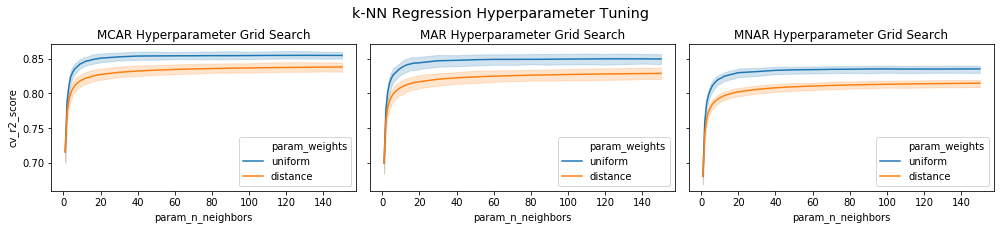

In [17]:
fig, axes = plt.subplots(1, 3, figsize=[14,3], sharex=True, sharey=True)
fig.suptitle('k-NN Regression Hyperparameter Tuning', y=1.05, size='x-large')
plot_knn_regression_grid_search(MCAR, 'MCAR', axes[0])
plot_knn_regression_grid_search(MAR, 'MAR', axes[1])
plot_knn_regression_grid_search(MNAR, 'MNAR', axes[2])
fig.tight_layout()

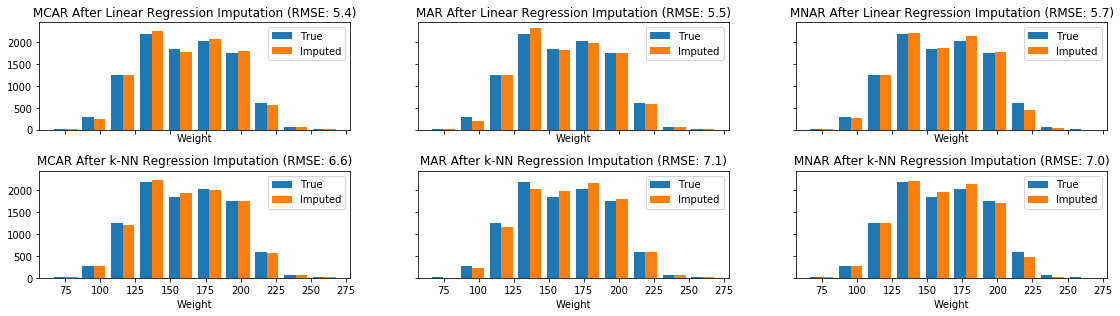

In [18]:
fig, axes = plt.subplots(2, 3, figsize=[16,4.5], sharex=True, sharey=True)
evaluate_imputation(impute_weight_using_linear_regression(MCAR), axes[0,0], 'MCAR After Linear Regression Imputation')
evaluate_imputation(impute_weight_using_linear_regression(MAR), axes[0,1], 'MAR After Linear Regression Imputation')
evaluate_imputation(impute_weight_using_linear_regression(MNAR), axes[0,2], 'MNAR After Linear Regression Imputation')
evaluate_imputation(impute_weight_using_knn_regression(MCAR), axes[1,0], 'MCAR After k-NN Regression Imputation')
evaluate_imputation(impute_weight_using_knn_regression(MAR), axes[1,1], 'MAR After k-NN Regression Imputation')
evaluate_imputation(impute_weight_using_knn_regression(MNAR), axes[1,2], 'MNAR After k-NN Regression Imputation')
fig.tight_layout()

## Betting on a Favorable Game

### Question
We start with \\$1. Each time we bet, we win the amount of our bet with probability .51 and lose the amount of our bet with probability .49. (Note that this is a favorable game since the win probability is greater than the loss probability.) Consider the strategy of betting some proportion $r$ of our holdings every time. How can we choose $r$ to make money the fastest?

### Solution
For this problem, we use the *strong law of large numbers* from probability theory.

---
**Strong law of large numbers (SLLN):**

Let $X_1, \ldots, X_n$ be i.i.id. with finite mean $\mu$. Then

$$P\left(\lim_{n \to \infty} \bar{X_n} = \mu \right) = 1.$$

---
Let $X_n$ be the amount of money we have after $n$ bets. Let

$$V_n = \begin{cases}1 + r~\text{if we win the}~n^{\text{th}}~\text{bet} \\ 1-r~\text{if we lose the}~n^{\text{th}}~\text{bet.}\end{cases}$$

Then $X_0 = 1$ and $X_n = V_n X_{n-1}$ for $n \geq 1$ by the definition of the game. Thus,

$$X_n = \prod_{i=1}^n V_i
\implies \log X_n = \sum_{i=1}^n \log V_i
\implies \lim_{n \to \infty} \frac{1}{n} \log X_n = \mathbb{E}[\log V_i]~\text{by the SLLN}
\implies X_n \approx e^{n\mathbb{E}[\log V_i]}~\text{for large n},$$

so we want to choose $r$ to maximize $\mathbb{E}[\log V_i]$. Now,

$$\mathbb{E}[\log V_i] = .51\log(1+r) + .49\log(1-r).$$

$$\frac{d}{dr} \mathbb{E}[\log V_i] = \frac{.51}{1+r} - \frac{.49}{1-r} \equiv 0 \implies .51(1-r) = .49(1+r) \implies r=.02.$$

$$\frac{d^2}{dr^2} \mathbb{E}[\log V_i] = -\frac{.51}{(1+r)^2} - \frac{.49}{(1-r)^2} < 0.$$

Therefore, $r = \underset{r}{\text{argmax}}~X_n \approx \underset{r}{\text{argmax}}~\mathbb{E}[\log V_i] = .02$ is the best choice of $r$ to make money the fastest.

We graph $\mathbb{E}[\log V_i]$ as a function of $r$ below.

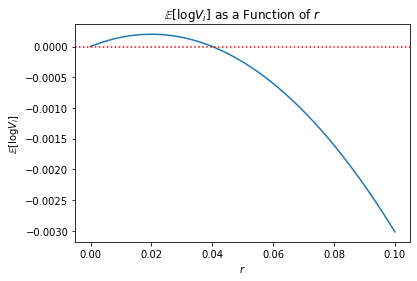

In [19]:
rgrid = np.linspace(0, .1)
plt.plot(rgrid, .51*np.log(1+rgrid) + .49*np.log(1-rgrid))
plt.title('$\mathbb{E}[\log V_i]$ as a Function of $r$')
plt.xlabel('$r$')
plt.ylabel('$\mathbb{E}[\log V_i]$');
plt.axhline(color='r', ls=':');

$.02$ indeed appears to be the maximizer of $\mathbb{E}[\log V_i]$.

If we choose $r = 0$ or $r = .04$,

$$\lim_{n \to \infty} \frac{1}{n} \log X_n = \mathbb{E}[\log V_i] = 0
\implies \lim_{n \to \infty} \log X_n = 0
\implies \lim_{n \to \infty} X_n = 1.
$$

In particular, if we choose $r = .04$, we will end up with end up with approximately \\$1 for large $n$, and if we choose $r = 0$, we are betting nothing on each round, so we will always have exactly $1.


If we choose $r > .04$,

$$\lim_{n \to \infty} \frac{1}{n} \log X_n = \mathbb{E}[\log V_i] < 0
\implies \lim_{n \to \infty} \log X_n = -\infty
\implies \lim_{n \to \infty} X_n = 0,
$$

so we are guaranteed to eventually lose all our money.

Intuitively, if we choose an $r$ too low, the rate at which we make money will be slow. On the other hand, if we choose an $r$ too high, our bets are riskier. If we choose an $r$ high enough, our bets will be so risky that we are gauranteed to eventually lose all our money. The choice of $r = .02$ appears to balance these properties the best.

We now empirically compare different choices of $r$. For each choice of $r$, we generate 1,000 simulations, each with 10,000 rounds of betting, and plot the median holdings at each round. We choose to plot medians instead of means due to the extremely large variation in payouts especially for choices of $r$ far from .02. Note that in the long run, both the median and mean will converge to the same number as $n \to \infty$.

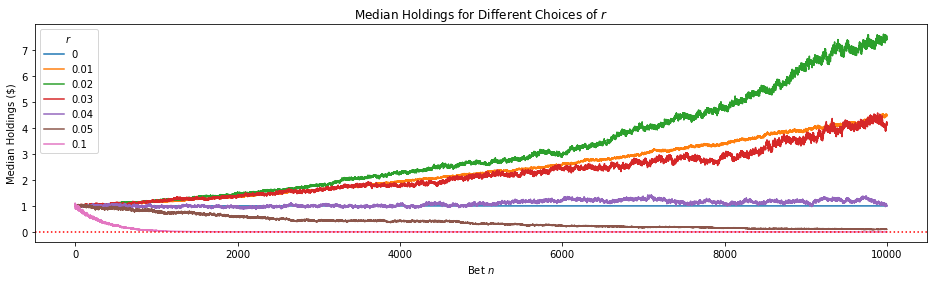

In [20]:
plt.figure(figsize=[16,4])
np.random.seed(0)
for r in 0,.01,.02,.03,.04,.05,.1:
    plt.plot(np.median([np.cumprod(np.random.choice([1+r, 1-r], size=10000, p=[.51,.49])) for _ in range(1000)], axis=0), label=r)
plt.title('Median Holdings for Different Choices of $r$')
plt.xlabel('Bet $n$')
plt.ylabel('Median Holdings ($)')
plt.legend(title='$r$')
plt.axhline(color='r', ls=':');

Conclusions:
- A choice of $r = .02$ results in the fastest growth as expected.
- As the choice of $r$ diverges from .02, the rate of growth lessens as expected.
- A choice of $r = 0$ results in exactly \\$1 at each round as expected, since we are not betting anything.
- A choice of $r = .04$ results in approximately \\$1 for large $n$ as expected.
- A choice of $r > .04$ eventually results in bankruptcy as expected.

## A Knights Problem

### Question
If a knight starts in the corner of a chessboard and on each step moves at random, how long on average does it take to return to its starting position?

<img src='img/knight.jpeg' style='width: 200px'/>

### Solution
For this problem, we use a result derived from graph theory and stochastic processes.

---
**Random walk on a graph:**

Let $G=(V,E)$ be a finite, undirected, connected graph. For each vertex $v \in V$, let $d(v)$ be the degree of $v$. For all $u$, $v \in V$, write $u \sim v$ if $u$ and $v$ are adjacent. For all $u$, $v \in V$, let

$$p(v,w) = \begin{cases}\frac{1}{d(v)}~\text{if}~w \sim v \\ 0~\text{otherwise.}\end{cases}$$

The discrete time Markov chain with state space $V$ and transition probabilities $p(v,w)$ is called the random walk on $G$. For example, if $p(5,2)=\frac{1}{3}$, if we are currently at vertex $5$, there is a $\frac{1}{3}$ probability we willl visit vertex $2$ next.

Note that the random walk is irreducible because the graph is connected. Since the random walk is irreducible and has a finite state space, the random walk has a unique stationary distribution. Here, the unique stationary distribution of the random walk is a probability distribution over $V$ that remains unchanged as time progresses.

Let $d=\sum_{w \in V} d(w)$ be the sum of the degrees of the vertices in $V$. For all $v \in V$, let $\pi(v)=\frac{d(v)}{d}$, so

$$\sum_{w \in V} \pi(w)p(w,v)
= \sum_{w \in V} \frac{d(w)}{d}p(w,v)
= \sum_{w: w \sim v} \frac{d(w)}{d} \cdot \frac{1}{d(w)}
= \sum_{w: w \sim v} \frac{1}{d}
= \frac{d(v)}{d}
= \pi(v),$$

so $\pi$ is a stationary distribution for the random walk on $G$. As a result, $\pi(v)=\frac{d(v)}{d}$ is the long run fraction of time that the random walk spends at vertex $v$.

---
Here, the knight's movement across the board is a random walk on the graph whose vertices are the 64 squares such that $v \sim w$ if a knight can move from square $v$ to square $w$. So $d(v)$ is the number of squares to which a knight can move from square $v$ and $\pi(v)=\frac{d(v)}{d}$ is the long run fraction of time that the knight spends at square $v$.

The plot below visualizes the number of squares to which a knight can move from each square of the chessboard.

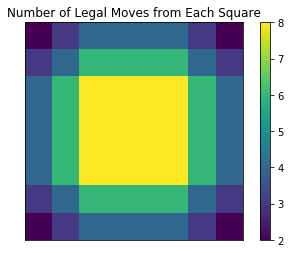

In [21]:
degrees = np.array([
    [2,3,4,4,4,4,3,2],
    [3,4,6,6,6,6,4,3],
    [4,6,8,8,8,8,6,4],
    [4,6,8,8,8,8,6,4],
    [4,6,8,8,8,8,6,4],
    [4,6,8,8,8,8,6,4],
    [3,4,6,6,6,6,4,3],
    [2,3,4,4,4,4,3,2],
])
plt.imshow(degrees)
plt.title('Number of Legal Moves from Each Square')
plt.xticks([])
plt.yticks([])
plt.colorbar();

In [22]:
np.sum(degrees)

336

Here, $d=336$. If $x$ is a corner square, $d(x)=2$, so $\pi(x)=\frac{d(x)}{d}=\frac{2}{336}=\frac{1}{168}$ is the long run fraction of time that the knight spends at square $x$. Therefore, the random walk's expected return time to $x$ is $\frac{1}{\pi(x)}=168$ moves, so it takes 168 moves on average for the knight to return to its starting position.

We now run a simulation to verify our solution.

In [23]:
MOVES = [(1,2),(2,1),(2,-1),(1,-2),(-1,-2),(-2,-1),(-2,1),(-1,2)]

def random_walk():
    x, y = x0, y0 = 0, 0
    count = 0
    while True:
        x, y = move(x, y)
        count += 1
        if x == x0 and y == y0:
            return count
        
def move(x, y):
    while True:
        dx, dy = MOVES[random.randint(0, len(MOVES)-1)]
        newx, newy = x + dx, y + dy
        if 0 <= newx < 8 and 0 <= newy < 8:
            return newx, newy

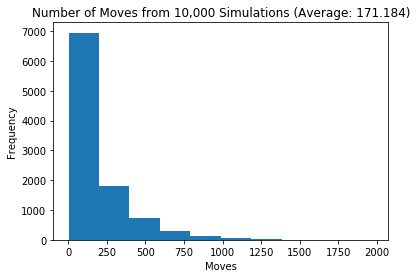

In [24]:
random.seed(0)
n_moves = [random_walk() for _ in range(10000)]
plt.hist(n_moves)
plt.title(f'Number of Moves from 10,000 Simulations (Average: {np.mean(n_moves):.3f})')
plt.xlabel('Moves')
plt.ylabel('Frequency');

Upon 10,000 random walk simulations, we see that the average number of moves for the knight to return to its starting position is around 168 as expected.

## The St. Petersburg Paradox

### Question
A casino offers a game where a fair coin is tossed until tails appears. The stake starts at \\$2 and is doubled every time heads appears. As soon as tails appears, the game ends and the player wins the pot, i.e., if the first tails comes on the nth toss, the player wins \\$$2^n$. What would be a fair price to enter the game?

### Solution
Let $X$ be the payout in dollars.
$$E[X] = \sum_{n=1}^{\infty} 2^n P(x=2^n) = \sum_{n=1}^{\infty} 2^n \cdot \frac{1}{2^n} = \sum_{n=1}^{\infty} 1 = \infty,$$
so the expected payout is an infinite amount of money assuming the casino has unlimited money (an unrealistic assumption in practice). Therefore, any price would be a fair price to enter the game, since the expected payout is infinitely large.

Note that the payout has a distribution of $2^N$, where $N \sim {\rm Geometric}\left(\frac{1}{2}\right)$. Using this fact, we now run a simulation to verify our solution.

count   10000000.00
mean          24.37
std         5195.21
min            2.00
25%            2.00
50%            4.00
75%            8.00
max      8388608.00
dtype: float64

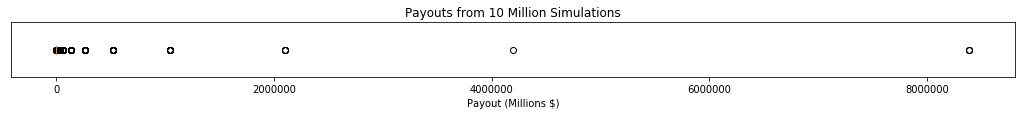

In [25]:
plt.figure(figsize=[18,1])
np.random.seed(0)
payouts = pd.Series(2**np.random.geometric(.5, 10000000))
plt.boxplot(payouts, vert=False)
plt.title('Payouts from 10 Million Simulations')
plt.xlabel('Payout (Millions $)')
plt.yticks([])
payouts.describe()

Upon 10 million simulations of payouts, we see that the data is plagued with extremely large outliers, consistent with the fact that the theoretical expected payout is infinitely large.

## The Cauchy Distribution

Mathematics is full of strange edge cases (referred to as *pathological* phenomena) which appear to defy our initial (naive) intuition and beliefs. In mathematics, a pathological phenomenon is one whose properties are considered atypically bad or counterintuitive.

For example, although one may initially believe that any continuous function must be differentiable at at least one point, there actually exists continuous functions that are nowhere differentiable. That is, continuity does not imply differentiability. An example is Brownian motion, a famous, continuous time stochastic process that is a continuous function of time but is nowhere differentiable. Intuitively, Brownian motion is nowhere differentiable because a very small change in time results in a very large change in position, to the point that a derivative does not exist. Visually, Brownian motion is nowhere differentiable because it possesses a fractral property; Brownian motion has the same, jagged appearance regardless of how much you "zoom" in as seen below.

<img src='img/BrownianMotion.gif' style='width: 500px'/>

The Weierstrass function is another, classic example of a continuous, nowhere differentiable function that also possesses a fractral property as seen below.

<img src='img/WeierstrassFunction.gif' style='width: 300px'/>

The Cauchy distribution is a famous pathalogical phenomena in probability theory. The Cauchy distribution is a symmetric probability distribution whose mean and variance are undefined (!). The fact that the mean of the Cauchy distribution is undefined is especially surprising, since one would expect the mean to lie on  the distribution's axis of symmetry. However, this is false; only the median and mode lie on the distribution's axis of symmetry. How can we empirically test whether or not the Cauchy distribution truly has an undefined mean? Here, we use the *law of large of numbers* from probability theory, a theorem that describes the result of performing the same experiment a large number of times.

---
**Law of large numbers (LLN):**

The average of the results obtained from a large number of trials should be close to the expected value, and will tend to become closer as more trials are performed.

---
We now generate large, random samples from the standard Normal, standard Exponential, and standard Cauchy distributions to see whether the (cumulative) sample means converge. We generate 4 samples of size 100,000 from each distribution.

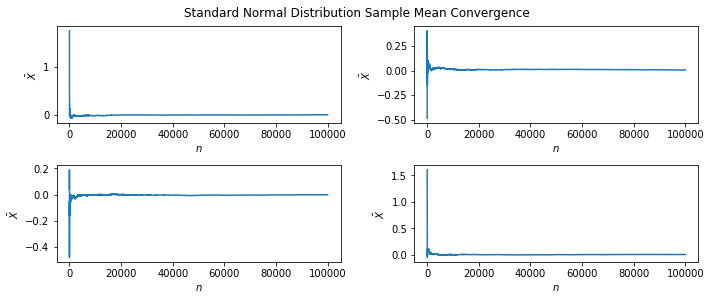

In [26]:
# Standard Normal distribution
fig, axes = plt.subplots(2, 2, figsize=[10,4])
fig.suptitle('Standard Normal Distribution Sample Mean Convergence', y=1.03)
np.random.seed(0)
for ax in axes.flatten():
    sample = np.random.standard_normal(100000)
    ax.plot(np.cumsum(sample) / np.arange(1, len(sample)+1))
    ax.set_xlabel('$n$')
    ax.set_ylabel(r'$\bar{X}$')
fig.tight_layout()

For the standard Normal distribution, we observe the law of large numbers. The cumulative sample mean approaches 0, the expected value, as the sample size increases.

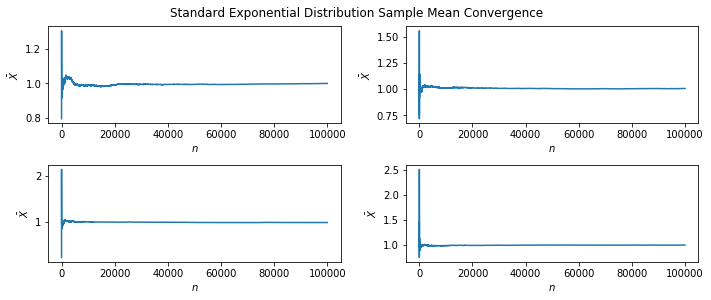

In [27]:
# Standard Exponential distribution
fig, axes = plt.subplots(2, 2, figsize=[10,4])
fig.suptitle('Standard Exponential Distribution Sample Mean Convergence', y=1.03)
np.random.seed(0)
for ax in axes.flatten():
    sample = np.random.standard_exponential(100000)
    ax.plot(np.cumsum(sample) / np.arange(1, len(sample)+1))
    ax.set_xlabel('$n$')
    ax.set_ylabel(r'$\bar{X}$')
fig.tight_layout()

Likewise, for the standard Normal distribution, we observe the law of large numbers. The cumulative sample mean approaches 1, the expected value, as the sample size increases.

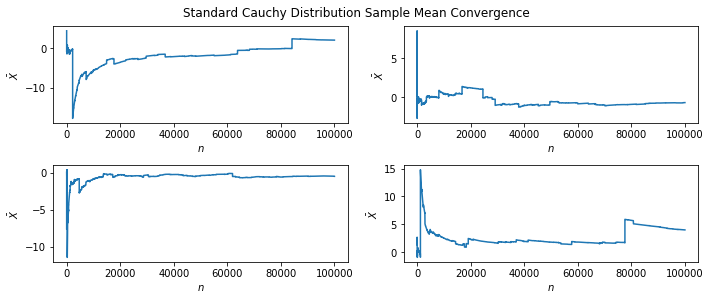

In [28]:
# Standard Cauchy distribution
fig, axes = plt.subplots(2, 2, figsize=[10,4])
fig.suptitle('Standard Cauchy Distribution Sample Mean Convergence', y=1.03)
np.random.seed(0)
for ax in axes.flatten():
    sample = np.random.standard_cauchy(100000)
    ax.plot(np.cumsum(sample) / np.arange(1, len(sample)+1))
    ax.set_xlabel('$n$')
    ax.set_ylabel(r'$\bar{X}$')
fig.tight_layout()

However, we observe something different for the standard Cauchy distribution. At times it appears that the cumulative mean approaches 0 but eventually the cumulative mean jumps away from 0 due to a new, extremely large outlier. Note that the law of large numbers does not apply here since the expected value of the (standard) Cauchy distribution is undefined.

In fact, if $X_1, \ldots, X_n$ are i.i.d. ${\rm Cauchy}(x_0, \gamma)$, the sample mean $\bar{X}$ itself is also ${\rm Cauchy}(x_0, \gamma)$ for any $n$. As a result, $\bar{X}$ will never converge to a constant, consistent with the fact that the mean of the Cauchy distribution is undefined.

# References
- https://brilliant.org/wiki/stationary-distributions/
- https://en.wikipedia.org/wiki/Cauchy_distribution
- https://en.wikipedia.org/wiki/Imputation_(statistics)
- https://en.wikipedia.org/wiki/Missing_data
- https://en.wikipedia.org/wiki/Pathological_(mathematics)
- https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
- http://web.mit.edu/8.334/www/grades/projects/projects17/OscarMickelin/fractals.html
- https://www.chess.com/analysis
- https://www.draw.io
- https://www.iriseekhout.com/missing-data/missing-data-mechanisms/mcar/
- https://www.johndcook.com/blog/2012/05/10/solutions-to-knights-random-walk/
- https://www.kaggle.com/mustafaali96/weight-height
- https://www.reddit.com/r/math/comments/2nltot/a_weierstrass_function_continuous_everywhere/
- https://www.theanalysisfactor.com/missing-data-mechanism/
- https://www-users.york.ac.uk/~mb55/intro/typemiss4.htm
- Fraenkel, Aaron. DSC 80, Winter 2019, UC San Diego, La Jolla, CA. Lecture.
- Schweinsberg, Jason. MATH 180A, Fall 2017, UC San Diego, La Jolla, CA. Lecture.
- Schweinsberg, Jason. MATH 180B, Winter 2018, UC San Diego, La Jolla, CA. Lecture.